In [1]:
import cv2
import glob
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
dataset_train = '1' #1 or 2 or _s1
dataset_test = '1' #1 or 2 or _s1
dataset_type = 'event' #event or frames
train_type = 'day' #night or rain or snow or day
test_type = 'night' #night or rain or snow or day
img_type = ''
read_type = ''
channel = -1
if dataset_type == 'event':
    img_type = 'jpg'
    read_type = cv2.IMREAD_GRAYSCALE
    channel = 1
elif dataset_type == 'frames':
    img_type = 'png'
    read_type = cv2.IMREAD_COLOR
    channel = 3

if len(dataset_train) == 1:
    sp = ' '
    ground = '/6dpose_list.txt'
    lat = 1
    lon = 2
    classResolution = 20
elif dataset_train[1] == 's':
    sp = ','
    ground = '/xypose.txt'
    lat = 0
    lon = 1
    classResolution = 20
elif dataset_train[1] == 'o':
    sp = ','
    ground = '/xypose.txt'
    lat = 0
    lon = 1
    classResolution = 20


images_train_f = [f for f in glob.glob('dataset'+dataset_train+'/'+dataset_type+'_'+train_type+'/*.'+img_type)]
images_train = []
images_train_f.sort()

for f in images_train_f:
    img = cv2.imread(f,read_type)
    img = img[:180][:]
    img = cv2.resize(img,dsize=(160,90), interpolation=cv2.INTER_AREA)
    images_train.append(img)

images_test_f = [f for f in glob.glob('dataset'+dataset_test+'/'+dataset_type+'_'+test_type+'/*.'+img_type)]
images_test = []
images_test_f.sort()

for f in images_test_f:
    img = cv2.imread(f,read_type)
    img = img[:180][:]
    img = cv2.resize(img,dsize=(160,90), interpolation=cv2.INTER_AREA)
    images_test.append(img)

location_file_train = open('dataset'+dataset_train+ground,'r')

XY_train = []
while True:
    line = location_file_train.readline()
    if not line: break
    l_split = line.split(sp)
    XY_train.append([float(l_split[lat]),float(l_split[lon])])
location_file_train.close()

In [3]:
print(images_train_f)
images_train_f = images_train_f[:]

['dataset1/event_day/left0000.jpg', 'dataset1/event_day/left0001.jpg', 'dataset1/event_day/left0002.jpg', 'dataset1/event_day/left0003.jpg', 'dataset1/event_day/left0004.jpg', 'dataset1/event_day/left0005.jpg', 'dataset1/event_day/left0006.jpg', 'dataset1/event_day/left0007.jpg', 'dataset1/event_day/left0008.jpg', 'dataset1/event_day/left0009.jpg', 'dataset1/event_day/left0010.jpg', 'dataset1/event_day/left0011.jpg', 'dataset1/event_day/left0012.jpg', 'dataset1/event_day/left0013.jpg', 'dataset1/event_day/left0014.jpg', 'dataset1/event_day/left0015.jpg', 'dataset1/event_day/left0016.jpg', 'dataset1/event_day/left0017.jpg', 'dataset1/event_day/left0018.jpg', 'dataset1/event_day/left0019.jpg', 'dataset1/event_day/left0020.jpg', 'dataset1/event_day/left0021.jpg', 'dataset1/event_day/left0022.jpg', 'dataset1/event_day/left0023.jpg', 'dataset1/event_day/left0024.jpg', 'dataset1/event_day/left0025.jpg', 'dataset1/event_day/left0026.jpg', 'dataset1/event_day/left0027.jpg', 'dataset1/event_day

In [4]:
print(len(images_train))
print(len(images_test))
print(len(XY_train))

7505
4296
7506


In [5]:
classSet = []
classSet_idx = []
maxClass = -1
frame_class = []
adj = []

for i in range(len(XY_train)):
    x = XY_train[i][0]
    y = XY_train[i][1]
    _x = int(x//classResolution)
    _y = int(y//classResolution)
    if not ([_x,_y] in classSet):
        maxClass += 1
        adj.append([])
        if ([_x+1,_y]in classSet):
            idx = classSet.index([_x+1,_y])
            classidx = classSet_idx[idx]
            adj[maxClass].append(classidx)
            adj[classidx].append(maxClass)
        if ([_x-1,_y]in classSet):
            idx = classSet.index([_x-1,_y])
            classidx = classSet_idx[idx]
            adj[maxClass].append(classidx)
            adj[classidx].append(maxClass)
        if ([_x,_y+1]in classSet):
            idx = classSet.index([_x,_y+1])
            classidx = classSet_idx[idx]
            adj[maxClass].append(classidx)
            adj[classidx].append(maxClass)
        if ([_x,_y-1]in classSet):
            idx = classSet.index([_x,_y-1])
            classidx = classSet_idx[idx]
            adj[maxClass].append(classidx)
            adj[classidx].append(maxClass)
        if ([_x+1,_y+1]in classSet):
            idx = classSet.index([_x+1,_y+1])
            classidx = classSet_idx[idx]
            adj[maxClass].append(classidx)
            adj[classidx].append(maxClass)
        if ([_x-1,_y-1]in classSet):
            idx = classSet.index([_x-1,_y-1])
            classidx = classSet_idx[idx]
            adj[maxClass].append(classidx)
            adj[classidx].append(maxClass)
        if ([_x-1,_y+1]in classSet):
            idx = classSet.index([_x-1,_y+1])
            classidx = classSet_idx[idx]
            adj[maxClass].append(classidx)
            adj[classidx].append(maxClass)
        if ([_x+1,_y-1]in classSet):
            idx = classSet.index([_x+1,_y-1])
            classidx = classSet_idx[idx]
            adj[maxClass].append(classidx)
            adj[classidx].append(maxClass)
        classSet.append([_x,_y])
        classSet_idx.append(maxClass)
        frame_class.append(maxClass)
    else:
        idx = classSet.index([_x,_y])
        frame_class.append(classSet_idx[idx])

In [6]:
location_file_test = open('dataset'+dataset_test+ground,'r')
frame_class_test = []
while True:
    line = location_file_test.readline()
    if not line: break
    l_split = line.split(sp)
    x = float(l_split[lat])
    y = float(l_split[lon])
    _x = int(x//classResolution)
    _y = int(y//classResolution)
    if ([_x,_y] in classSet):
        idx = classSet.index([_x,_y])
        frame_class_test.append(classSet_idx[idx])
    else:
        frame_class_test.append(-1)
location_file_test.close()

print(len(frame_class_test))

4297


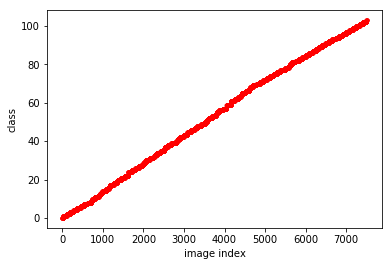

In [7]:
plt.plot(frame_class,'r.')
plt.xlabel('image index', fontsize=10)
plt.ylabel('class',fontsize=10)
plt.show()

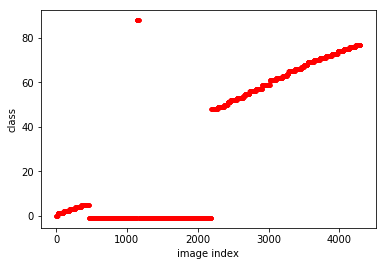

In [8]:
plt.plot(frame_class_test,'r.')
plt.xlabel('image index', fontsize=10)
plt.ylabel('class',fontsize=10)
plt.show()

In [9]:
print(len(frame_class))

7506


In [10]:
train_x = []
train_y = []

print(train_x)

for k, img in enumerate(images_train):
    img_ = cv2.GaussianBlur(img,(3,3),0)
    img_ = img_/255.0
    '''
    if k%5 == 0: 
        M = np.float32([[1,0,16],[0,1,0]])
        img_ = cv2.warpAffine(img_,M,(160,90))
    elif k%5 == 1:
        M = np.float32([[1,0,-16],[0,1,0]])
        img_ = cv2.warpAffine(img_,M,(160,90))
    '''
    train_x.append(img_)
    train_y.append(frame_class[k])

train_x = np.array(train_x)
train_y = np.array(train_y)

[]


In [11]:
print()

()


In [12]:
train_x = train_x.reshape(len(train_x), channel, 90, 160)
train_x = torch.from_numpy(train_x).float()
train_y = torch.from_numpy(train_y).long()

train_x = train_x.cuda()
train_y = train_y.cuda()

print(train_x.shape)
print(train_y.shape)

torch.Size([7505, 1, 90, 160])
torch.Size([7505])


In [13]:
N = int((max(train_y)+1).cpu())
N

104

In [14]:
train = TensorDataset(train_x, train_y)

train_loader = DataLoader(train, batch_size = 64, shuffle = True)

In [15]:
class ENet(nn.Module):
    def __init__(self):
        super(ENet, self).__init__()
        self.conv1 = nn.Conv2d(channel, 6, 5, stride=1, padding=2)
        self.conv1_bn = nn.BatchNorm2d(num_features=6)
        self.conv2 = nn.Conv2d(6, 16, 5, stride=1, padding=2)
        self.conv2_bn = nn.BatchNorm2d(num_features=16)
        self.conv3 = nn.Conv2d(16, 32, 5, stride=1, padding=2)
        self.fc1   = nn.Linear(32*10*22, 2*N)
        self.fc2   = nn.Linear(2*N, int(1.5*N))
        self.fc3   = nn.Linear(int(1.5*N), N)
    def forward(self, x):
        x = self.conv1_bn(F.max_pool2d(F.relu(self.conv1(x)), (2,2)))
        x = self.conv2_bn(F.max_pool2d(F.relu(self.conv2(x)), (2,2)))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        x = x.view(-1, 32*10*22)#32 * 19 * 37)
        x = F.relu(self.fc1(F.dropout(x)))
        x = F.relu(self.fc2(F.dropout(x)))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)
    
model = ENet()
model.cuda()



ENet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv1_bn): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=7040, out_features=208, bias=True)
  (fc2): Linear(in_features=208, out_features=156, bias=True)
  (fc3): Linear(in_features=156, out_features=104, bias=True)
)

In [16]:

torch.cuda.device(0)

In [17]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001)
for epoch in range(1000):
    total_loss = 0
    
    for t_x, t_y in train_loader:
        
        t_x, t_y = Variable(t_x), Variable(t_y)
        
        optimizer.zero_grad()
        
        output = model(t_x)
        
        loss = criterion(output, t_y)
        
        loss.backward()
        
        optimizer.step()
        
        total_loss += loss.data
        
    if (epoch+1)%1 == 0:
        print(epoch+1, total_loss)

(1, tensor(549.0407, device='cuda:0'))
(2, tensor(547.1081, device='cuda:0'))
(3, tensor(545.6558, device='cuda:0'))
(4, tensor(543.5336, device='cuda:0'))
(5, tensor(541.2032, device='cuda:0'))
(6, tensor(538.8081, device='cuda:0'))
(7, tensor(535.7643, device='cuda:0'))
(8, tensor(532.2751, device='cuda:0'))
(9, tensor(528.5558, device='cuda:0'))
(10, tensor(523.6266, device='cuda:0'))
(11, tensor(518.1820, device='cuda:0'))
(12, tensor(511.1464, device='cuda:0'))
(13, tensor(504.0036, device='cuda:0'))
(14, tensor(495.5996, device='cuda:0'))
(15, tensor(483.7270, device='cuda:0'))
(16, tensor(470.1539, device='cuda:0'))
(17, tensor(456.8693, device='cuda:0'))
(18, tensor(440.3056, device='cuda:0'))
(19, tensor(421.8719, device='cuda:0'))
(20, tensor(403.7298, device='cuda:0'))
(21, tensor(382.3538, device='cuda:0'))
(22, tensor(360.8027, device='cuda:0'))
(23, tensor(340.2941, device='cuda:0'))
(24, tensor(322.4251, device='cuda:0'))
(25, tensor(304.9962, device='cuda:0'))
(26, tens

(208, tensor(15.7644, device='cuda:0'))
(209, tensor(14.7425, device='cuda:0'))
(210, tensor(15.3178, device='cuda:0'))
(211, tensor(15.2732, device='cuda:0'))
(212, tensor(14.8731, device='cuda:0'))
(213, tensor(15.7012, device='cuda:0'))
(214, tensor(14.6020, device='cuda:0'))
(215, tensor(14.9982, device='cuda:0'))
(216, tensor(14.7159, device='cuda:0'))
(217, tensor(14.6391, device='cuda:0'))
(218, tensor(14.4761, device='cuda:0'))
(219, tensor(14.4978, device='cuda:0'))
(220, tensor(14.3696, device='cuda:0'))
(221, tensor(14.8214, device='cuda:0'))
(222, tensor(15.0970, device='cuda:0'))
(223, tensor(13.6210, device='cuda:0'))
(224, tensor(13.7719, device='cuda:0'))
(225, tensor(13.9235, device='cuda:0'))
(226, tensor(14.6636, device='cuda:0'))
(227, tensor(15.3682, device='cuda:0'))
(228, tensor(13.2643, device='cuda:0'))
(229, tensor(13.6797, device='cuda:0'))
(230, tensor(13.1086, device='cuda:0'))
(231, tensor(13.7447, device='cuda:0'))
(232, tensor(13.3883, device='cuda:0'))


(416, tensor(5.9561, device='cuda:0'))
(417, tensor(6.2745, device='cuda:0'))
(418, tensor(7.0779, device='cuda:0'))
(419, tensor(6.8254, device='cuda:0'))
(420, tensor(6.2099, device='cuda:0'))
(421, tensor(6.4584, device='cuda:0'))
(422, tensor(6.8860, device='cuda:0'))
(423, tensor(6.4879, device='cuda:0'))
(424, tensor(6.6070, device='cuda:0'))
(425, tensor(6.7337, device='cuda:0'))
(426, tensor(6.3152, device='cuda:0'))
(427, tensor(6.6972, device='cuda:0'))
(428, tensor(6.7980, device='cuda:0'))
(429, tensor(6.5579, device='cuda:0'))
(430, tensor(6.7960, device='cuda:0'))
(431, tensor(6.4133, device='cuda:0'))
(432, tensor(6.3418, device='cuda:0'))
(433, tensor(5.4748, device='cuda:0'))
(434, tensor(6.4027, device='cuda:0'))
(435, tensor(6.1290, device='cuda:0'))
(436, tensor(6.3623, device='cuda:0'))
(437, tensor(6.2951, device='cuda:0'))
(438, tensor(6.0570, device='cuda:0'))
(439, tensor(5.8620, device='cuda:0'))
(440, tensor(6.4667, device='cuda:0'))
(441, tensor(6.2363, devi

(627, tensor(4.1125, device='cuda:0'))
(628, tensor(4.3635, device='cuda:0'))
(629, tensor(4.1726, device='cuda:0'))
(630, tensor(4.2205, device='cuda:0'))
(631, tensor(4.1146, device='cuda:0'))
(632, tensor(3.8476, device='cuda:0'))
(633, tensor(4.3903, device='cuda:0'))
(634, tensor(3.6472, device='cuda:0'))
(635, tensor(3.9421, device='cuda:0'))
(636, tensor(4.3942, device='cuda:0'))
(637, tensor(4.0505, device='cuda:0'))
(638, tensor(3.6621, device='cuda:0'))
(639, tensor(4.2046, device='cuda:0'))
(640, tensor(3.6418, device='cuda:0'))
(641, tensor(4.0157, device='cuda:0'))
(642, tensor(3.8880, device='cuda:0'))
(643, tensor(3.8859, device='cuda:0'))
(644, tensor(3.5798, device='cuda:0'))
(645, tensor(3.4581, device='cuda:0'))
(646, tensor(3.8237, device='cuda:0'))
(647, tensor(4.2281, device='cuda:0'))
(648, tensor(4.2568, device='cuda:0'))
(649, tensor(3.7207, device='cuda:0'))
(650, tensor(4.3084, device='cuda:0'))
(651, tensor(4.2349, device='cuda:0'))
(652, tensor(3.4008, devi

(838, tensor(2.7728, device='cuda:0'))
(839, tensor(2.6271, device='cuda:0'))
(840, tensor(2.9377, device='cuda:0'))
(841, tensor(2.5420, device='cuda:0'))
(842, tensor(2.6169, device='cuda:0'))
(843, tensor(2.9680, device='cuda:0'))
(844, tensor(2.8471, device='cuda:0'))
(845, tensor(2.5299, device='cuda:0'))
(846, tensor(2.8574, device='cuda:0'))
(847, tensor(2.6609, device='cuda:0'))
(848, tensor(2.8739, device='cuda:0'))
(849, tensor(2.7857, device='cuda:0'))
(850, tensor(2.7589, device='cuda:0'))
(851, tensor(2.3652, device='cuda:0'))
(852, tensor(2.6856, device='cuda:0'))
(853, tensor(2.8842, device='cuda:0'))
(854, tensor(2.6589, device='cuda:0'))
(855, tensor(2.7663, device='cuda:0'))
(856, tensor(3.2843, device='cuda:0'))
(857, tensor(3.1454, device='cuda:0'))
(858, tensor(2.7305, device='cuda:0'))
(859, tensor(2.5443, device='cuda:0'))
(860, tensor(2.4430, device='cuda:0'))
(861, tensor(3.1083, device='cuda:0'))
(862, tensor(3.1396, device='cuda:0'))
(863, tensor(2.9082, devi

In [38]:
test_x = []
test_y = []

for k, img in enumerate(images_test):
    if k%5 != 0:
        continue
    if k>=10000:
        break
    img_ = cv2.GaussianBlur(img,(3,3),0)
    img_ = img_/255.0
    #img_ = img_[:180][:]
    #img_ = cv2.resize(img_,dsize=(160,90), interpolation=cv2.INTER_AREA)
    test_x.append(img_)
    test_y.append(frame_class_test[k])
    
test_x = np.array(test_x)
test_y = np.array(test_y)

In [39]:
test_x = test_x.reshape(len(test_x), channel, 90, 160)

test_x = torch.from_numpy(test_x).float()
test_y = torch.from_numpy(test_y).long()

test_x = test_x.cuda()
test_y = test_y.cuda()

print(test_x.shape)
print(test_y.shape)

torch.Size([860, 1, 90, 160])
torch.Size([860])


In [40]:
train_x = None
train_y = None
images_train = None
torch.cuda.empty_cache()

In [41]:
test_x, test_y = Variable(test_x), Variable(test_y)
import time
start = time.time() 
 
result_test = model(test_x).data
global_max_value = torch.max(result_test, 1)[0]
global_max_index = torch.max(result_test, 1)[1]
global_max_value = global_max_value.cpu().numpy()
global_max_index = global_max_index.cpu().numpy()
test_y = test_y.cpu().numpy()



result_test = result_test.cpu().numpy()
p = np.exp(result_test)
global_max_value = np.exp(global_max_value)
for i in range(len(result_test)):

    print(p[i])
    
match_result = []
acc = []
precision = []
recall = []
len_Q = len(p)
len_D = N
lost = True
position = -1
th1 = 0.97
th2 = 0.01
K = 2
'''
R = range(0,26)
for i in range(len(R)):
    R[i] /= 25.0
    '''

P = []
TN = []
FP = []
FN = []
FX = []

#for th1 in R:
    #for th2 in R:
for i in range(len_Q):
    if lost:
        if global_max_value[i] < th1:
            match_result.append(-1)
            lost = True
        else:
            match_result.append(global_max_index[i])
            lost = False
            position = global_max_index[i]
    else:
        left = max(position-K,0)
        right = min(position+K+1,len_D-1)
        local_max_value = max(p[i][left:right])
        local_max_index = p[i][left:right].argmax() + left
        if local_max_value < th2:

            if global_max_value[i] < th1:
                match_result.append(-1)
                lost = True
            else:
                match_result.append(global_max_index[i])
                position = global_max_index[i]
                lost = False
        else:
            match_result.append(local_max_index)
            position = local_max_index
            lost = False
print("time :", time.time() - start) 


[  3.94360796e-02   3.92055541e-01   4.91670907e-01   3.24820903e-05
   1.04573933e-10   3.95084000e-11   1.15100529e-09   4.95821553e-07
   7.56139010e-02   5.27734766e-11   2.58579846e-09   6.88734644e-07
   9.00700942e-20   3.90012952e-11   3.84752039e-12   3.29632611e-18
   2.07041406e-08   1.64457672e-21   1.25412472e-20   2.16220997e-07
   8.15487400e-11   1.10176805e-15   1.73164801e-20   1.40980259e-13
   6.99730985e-12   1.77742022e-11   1.93637927e-04   9.83778128e-11
   3.62135940e-16   7.74360909e-14   2.75905262e-14   9.34006344e-13
   3.31541630e-12   1.90297866e-09   3.55650817e-16   4.91691665e-08
   1.40598809e-11   4.19485807e-10   2.00856642e-09   1.85790286e-10
   5.80829178e-12   2.96831922e-18   3.58115935e-18   3.92637149e-19
   1.46201993e-13   1.86267210e-17   5.12285743e-12   1.05929686e-12
   1.31343234e-06   3.69261045e-11   3.31744816e-15   3.70339854e-13
   1.49629895e-14   6.98465364e-20   2.66521617e-16   1.46687640e-18
   2.39166246e-18   9.46702254e-22

   1.12585715e-13   1.36640943e-09   4.10199462e-13   1.75445487e-12]
[  1.62610759e-05   7.10606542e-08   3.26471017e-10   1.09279554e-08
   1.76434121e-08   1.98466068e-07   2.77085306e-08   3.09369774e-09
   9.25983856e-12   1.07814833e-11   6.46109694e-11   9.70856604e-07
   4.71137417e-03   1.51596691e-08   2.43127083e-08   8.69406977e-12
   9.81757807e-14   1.53445236e-14   9.66538454e-15   4.51380211e-10
   3.01064031e-17   1.92550640e-16   1.58682170e-07   1.20309710e-06
   1.67998650e-07   1.93197325e-09   1.34633359e-04   3.74786763e-13
   2.03756378e-13   2.30908000e-15   7.97097414e-13   1.01271647e-11
   1.08391451e-09   3.08586041e-16   2.60053706e-17   2.22641419e-11
   9.24903166e-13   1.16002665e-08   3.57941410e-09   9.03446999e-05
   3.12765880e-09   2.15444573e-09   1.45752826e-10   1.10135534e-09
   1.86809768e-06   9.74146315e-05   3.37980673e-05   3.91585758e-07
   7.45840816e-06   1.63218285e-14   7.71063753e-07   8.41710516e-06
   8.85956197e-08   1.30944131e-1

   1.47529775e-13   1.49253096e-10   3.19853871e-13   1.13838019e-11]
[  5.66363155e-07   3.43078064e-08   3.11431259e-09   4.76703903e-08
   2.02697912e-08   3.77355347e-04   1.11086096e-03   4.44501802e-06
   4.48652671e-09   2.76562062e-08   5.72739252e-11   1.21820082e-10
   1.42715850e-09   4.04756008e-13   2.58183943e-14   4.42887893e-10
   5.40526179e-10   5.98793931e-11   8.37042988e-17   4.77338238e-11
   2.10362820e-08   2.29041504e-12   3.79053963e-05   1.29321677e-07
   6.92233055e-13   4.29132313e-10   1.52477391e-08   3.18870153e-09
   7.97990506e-05   1.36998271e-08   1.01399087e-06   7.72903519e-09
   3.11993098e-09   3.59418939e-10   9.08957978e-11   4.14602454e-07
   2.92853880e-10   2.70720585e-10   1.03383124e-08   1.19594560e-07
   5.27183784e-06   2.03462059e-05   1.74268807e-05   7.03738770e-05
   3.44404270e-07   3.25002134e-07   2.59096868e-08   4.64836667e-08
   1.08071899e-05   1.58733201e-05   7.91527555e-07   3.85556341e-05
   6.80539961e-05   2.43498269e-0

   1.40501442e-08   1.50730006e-08   4.01701372e-12   1.33400899e-08]
[  1.57015290e-09   1.33640850e-11   1.01981437e-08   2.53616661e-09
   6.45513157e-12   2.22562889e-07   2.21239585e-13   3.28004894e-08
   4.77305093e-07   4.03165012e-09   3.85361476e-09   1.67464691e-07
   8.36404390e-10   2.52905839e-11   6.62161298e-11   7.94245913e-09
   3.24177174e-09   1.71215262e-07   1.08997700e-08   3.59407168e-05
   1.24492336e-08   2.45234190e-07   9.99921799e-01   3.20277445e-06
   1.13723011e-07   8.36217692e-14   1.10123413e-08   2.37227500e-08
   7.59474677e-14   3.64452053e-14   4.90300044e-06   6.58179244e-09
   6.33763224e-13   1.15324700e-16   8.76975770e-10   1.49556867e-10
   2.43728368e-06   2.63853217e-05   1.43224155e-09   1.58815239e-09
   1.31940880e-07   3.76744360e-08   1.56342894e-09   3.70670562e-13
   2.46748868e-06   2.35643594e-09   7.52222503e-12   4.49614372e-14
   2.23400708e-11   2.00006027e-13   3.50764502e-13   1.83613822e-14
   4.14088658e-15   5.24327491e-1

   5.63309605e-14   3.84783692e-04   2.13627372e-05   8.35353786e-10]
[  1.35877838e-06   1.07646487e-12   4.63129452e-16   3.15521611e-12
   6.99117574e-15   1.86425597e-11   6.07132389e-09   2.11595035e-15
   2.05276720e-15   4.81975147e-17   1.05141469e-15   2.27848393e-13
   2.60542708e-21   1.61767483e-18   2.16333321e-19   1.75286504e-17
   1.07471176e-14   8.01737766e-23   2.51970522e-28   1.47588164e-15
   2.67962008e-24   1.57025856e-23   1.83471679e-18   9.97904592e-15
   2.56235593e-12   3.74673843e-13   4.18962918e-06   6.88451891e-08
   3.24578141e-05   9.77435618e-15   9.83689325e-16   3.29584077e-15
   4.22051608e-06   2.22219629e-08   7.19435428e-16   1.43279819e-10
   5.44216365e-13   4.66041233e-16   8.28973656e-20   5.81848107e-16
   3.70702348e-17   4.90073378e-17   7.19608381e-16   4.46998193e-20
   1.19951994e-18   1.91985849e-09   8.05867872e-12   2.52771451e-06
   2.56152481e-01   4.90601547e-03   7.20309326e-03   7.28709102e-01
   3.03984561e-04   3.50817530e-1

   3.47549143e-21   1.05302368e-16   3.86704739e-19   1.34064563e-16]
[  7.42640394e-10   4.44547090e-12   4.17926273e-13   9.45234234e-13
   5.54471562e-14   1.45042082e-04   4.29843021e-06   2.27474972e-09
   9.81406423e-09   5.13008342e-12   1.26151436e-08   1.44426408e-03
   6.30271599e-11   2.22771169e-13   5.33722575e-14   1.01286506e-15
   2.18067912e-15   3.20666142e-14   1.69932167e-12   3.25849972e-11
   2.68011213e-08   9.75638903e-10   2.74867108e-12   3.75229375e-10
   8.38604360e-13   5.99454704e-14   5.12424592e-08   6.60561814e-11
   6.37494547e-14   6.93856621e-16   9.37565284e-17   2.02546105e-11
   7.81023585e-15   4.09196612e-18   5.26199631e-16   1.93269066e-14
   7.36043876e-13   1.47724211e-11   9.28509092e-09   1.03414599e-02
   2.71751796e-05   2.11453198e-06   5.02876355e-04   1.47693527e-05
   5.36781627e-05   6.71492284e-09   5.55727062e-11   1.89389546e-11
   7.42329621e-06   6.14059983e-11   5.17131316e-09   1.06405260e-10
   2.21992150e-06   6.79608638e-0

   7.07866127e-11   9.35725661e-16   1.18946545e-11   9.76567827e-10]
[  6.64179242e-06   3.36200833e-06   1.02266462e-07   4.52841462e-08
   1.04231494e-05   2.89029302e-03   1.63065568e-02   5.22120893e-02
   6.44026998e-10   8.98329766e-09   5.15607007e-06   1.86605342e-10
   4.15023787e-05   2.03930095e-10   1.21958010e-07   9.72770969e-04
   6.72567126e-07   1.56341721e-05   7.91705907e-14   1.43838761e-07
   1.39319001e-08   2.16873985e-09   4.70281549e-04   3.93973751e-05
   1.25307622e-07   1.16767118e-09   8.43214121e-09   1.69810448e-07
   1.25086677e-04   2.17771415e-07   2.90638202e-09   3.39942332e-08
   2.44294679e-05   7.66136460e-11   3.24942647e-07   3.18480573e-07
   4.45824044e-05   3.24323628e-06   2.70271357e-07   1.45655167e-06
   5.70003351e-07   6.45552348e-07   8.29964790e-07   2.40574104e-06
   8.00096700e-07   4.53221446e-07   7.92667834e-08   1.06662768e-09
   3.19368718e-03   6.14029005e-09   7.82579093e-07   3.81159884e-06
   6.83727130e-10   3.60794047e-0

   1.86509812e-08   1.11888589e-11   6.05079441e-12   4.21263650e-07]
[  2.43301950e-12   9.61158042e-10   1.78226394e-08   2.55554133e-09
   6.70759631e-14   8.05400798e-12   6.05686364e-06   1.42314169e-08
   7.52526788e-08   9.01674568e-11   3.52191478e-07   3.75670695e-09
   1.61780626e-12   4.84194455e-11   4.19076791e-08   4.65754768e-10
   3.64772518e-11   1.21023038e-12   1.01063358e-09   4.01467055e-08
   8.61886257e-12   3.30860406e-04   1.21550965e-08   2.72961120e-09
   6.91119695e-09   6.32445904e-07   6.29456531e-09   1.20887744e-10
   1.11522819e-10   1.87968651e-12   1.88931673e-15   5.66873666e-15
   1.10866460e-09   1.81869778e-13   1.59755596e-12   3.09716627e-11
   1.26468425e-09   2.13145951e-12   1.03329931e-11   5.48673961e-06
   1.01698284e-07   2.00583473e-11   8.14743106e-10   1.44201149e-08
   1.61343605e-09   5.64803725e-11   4.48912629e-10   4.95337060e-09
   2.19732090e-08   4.31969426e-07   4.46300668e-08   1.63646671e-13
   9.94165874e-15   4.00960584e-1

In [37]:
result_test = result_test.cpu().numpy()
p = np.exp(result_test)
global_max_value = np.exp(global_max_value)
for i in range(len(result_test)):

    print(p[i])
    
match_result = []
acc = []
precision = []
recall = []
len_Q = len(p)
len_D = N
lost = True
position = -1
th1 = 0.97
th2 = 0.01
K = 2
'''
R = range(0,26)
for i in range(len(R)):
    R[i] /= 25.0
    '''

P = []
TN = []
FP = []
FN = []
FX = []

#for th1 in R:
    #for th2 in R:
for i in range(len_Q):
    if lost:
        if global_max_value[i] < th1:
            match_result.append(-1)
            lost = True
        else:
            match_result.append(global_max_index[i])
            lost = False
            position = global_max_index[i]
    else:
        left = max(position-K,0)
        right = min(position+K+1,len_D-1)
        local_max_value = max(p[i][left:right])
        local_max_index = p[i][left:right].argmax() + left
        if local_max_value < th2:

            if global_max_value[i] < th1:
                match_result.append(-1)
                lost = True
            else:
                match_result.append(global_max_index[i])
                position = global_max_index[i]
                lost = False
        else:
            match_result.append(local_max_index)
            position = local_max_index
            lost = False
print("time :", time.time() - start) 

[  7.77073279e-02   7.16133237e-01   4.64020879e-04   1.36706184e-08
   1.08693070e-13   3.64953781e-13   4.09907731e-13   8.25375532e-11
   1.26388189e-08   6.73130349e-15   3.59131408e-16   6.75462218e-07
   4.92685640e-20   8.73123527e-14   1.29100198e-19   1.48958118e-22
   1.76151314e-12   3.28078895e-22   1.44644027e-24   9.15734599e-10
   2.36318804e-16   2.42313937e-21   4.96067296e-19   7.62531019e-19
   2.52826803e-18   5.66574465e-18   8.14984435e-09   4.05888956e-15
   2.68902311e-22   2.92597345e-23   1.78386591e-19   6.04599148e-17
   6.85765595e-22   4.74879705e-16   6.48116659e-22   2.41573361e-09
   6.80286380e-14   7.70672554e-11   3.87241356e-15   3.40527785e-15
   4.82237947e-14   1.20540723e-22   3.41606458e-22   4.78878297e-23
   5.72893512e-14   2.80833641e-16   7.83534045e-13   2.99498619e-14
   2.20056086e-06   6.50536180e-16   2.71122806e-16   5.78992166e-15
   3.85653532e-12   2.25473512e-18   6.68880954e-16   6.55697438e-19
   5.44210268e-20   6.51956708e-25

   2.45894862e-05   4.18989733e-03   1.28944848e-05   3.80178448e-04]
[  1.21481836e-09   1.61523031e-10   5.52060567e-13   6.04439554e-11
   2.96593028e-11   2.77472485e-04   2.63286226e-10   3.65423318e-07
   5.39547873e-09   3.79373494e-04   3.28422095e-10   1.51886337e-09
   1.13003375e-06   5.17961433e-13   5.46686758e-11   2.81116677e-08
   3.73042752e-07   4.41338852e-06   1.51822249e-10   3.42513147e-08
   2.72617355e-04   6.30979866e-06   6.51644776e-04   2.70267861e-08
   1.18181323e-14   1.57037161e-09   2.58716994e-07   5.24271793e-10
   4.03003014e-06   2.43849141e-09   3.42998450e-04   6.09794952e-08
   8.12379775e-10   1.43316792e-09   3.65711443e-08   9.71385475e-07
   9.91699256e-09   6.28113298e-07   4.65097901e-06   4.22009980e-05
   4.06602174e-02   1.25309722e-02   3.99850667e-01   2.64069095e-04
   3.59602927e-05   5.52997086e-03   4.98919794e-11   3.97586781e-08
   9.92202759e-03   6.58723351e-08   1.71828098e-08   1.14230363e-06
   6.55257327e-06   4.42434801e-0

[  8.15396106e-06   3.18806627e-07   4.89611523e-07   3.77401921e-05
   6.03000274e-07   2.53345922e-09   1.84958174e-06   3.98390265e-10
   1.91340255e-09   1.97970676e-12   2.62021151e-11   1.39160666e-05
   1.80576365e-09   3.12403825e-10   1.70761259e-13   3.20851662e-13
   2.03292799e-10   2.01202965e-12   1.36958854e-15   6.18771139e-07
   1.30826280e-14   3.93890385e-16   2.69278244e-09   8.75598175e-07
   2.54352693e-04   4.53421620e-07   1.23987498e-04   5.76980907e-09
   8.97318071e-12   7.82289747e-14   8.59692702e-16   2.50476861e-10
   3.18813274e-11   1.17424299e-11   1.88473132e-15   2.16063900e-09
   8.72367900e-10   1.41206471e-07   3.22258806e-08   2.23756302e-04
   1.21164830e-05   5.46481189e-08   2.55227506e-11   1.70657974e-10
   1.35246495e-07   1.32027235e-05   1.73366233e-03   7.23472750e-03
   9.72841144e-01   7.29240696e-11   4.14160638e-07   2.56301755e-05
   3.59817676e-07   1.57975508e-11   3.17743820e-06   1.94561323e-07
   6.56150576e-07   1.69210466e-06

   2.18963722e-10   5.09668152e-15   8.70833353e-14   2.23412444e-09]
[  2.48463436e-08   8.26773094e-11   9.89423086e-08   4.71664617e-11
   1.04248566e-13   1.88855440e-04   4.91989738e-09   2.03163157e-08
   6.18061404e-06   1.28338490e-06   2.75192008e-07   3.35712721e-05
   8.01543578e-08   2.11500677e-07   7.39695388e-11   5.91327353e-06
   1.20072424e-10   7.54687193e-08   3.98804108e-03   1.26528293e-01
   2.88210389e-09   8.58939961e-02   6.99171498e-02   5.30700950e-09
   3.35652506e-09   2.26477948e-09   7.11752594e-01   2.19931491e-04
   8.58836453e-14   1.26991838e-15   2.67595439e-08   2.43353254e-10
   5.34228304e-12   1.34406906e-12   2.62935718e-08   2.26550848e-10
   8.46582182e-09   1.31177238e-08   1.69577866e-13   6.59375443e-09
   2.93443532e-04   6.02875207e-06   9.57805391e-10   2.98030559e-11
   1.09345870e-04   1.97057147e-04   1.00781682e-10   4.71731595e-13
   4.41532553e-04   7.93198580e-12   5.08144771e-09   1.08022673e-12
   3.78418339e-14   2.97927158e-0

[  6.49943210e-09   7.84436145e-12   5.35382455e-14   1.70103810e-11
   6.91116331e-11   1.43568861e-04   1.32879688e-06   4.22900293e-09
   2.88738189e-08   1.07127889e-08   9.68604197e-10   3.37842393e-11
   1.72292062e-07   3.43454182e-10   2.23449551e-05   2.81038170e-04
   1.52141855e-08   3.04000196e-06   4.67321060e-13   2.02094430e-09
   3.88511552e-08   1.56505598e-06   2.10373364e-05   3.73648072e-05
   2.26929924e-08   2.09332462e-09   8.14971747e-04   1.12455200e-06
   8.35404906e-04   5.83650581e-06   1.36930626e-04   1.74795623e-05
   3.38266417e-03   5.24245287e-08   4.02585696e-03   5.81778113e-05
   1.10456267e-05   1.69450371e-03   1.22057154e-05   2.22600902e-05
   3.16349656e-06   3.25204113e-08   1.87844962e-05   1.80338887e-07
   9.56086978e-08   1.73709468e-05   7.26865124e-10   1.33642459e-06
   6.46077216e-01   1.50117772e-02   2.86927616e-06   7.70694023e-05
   1.82201584e-05   2.53064662e-01   1.06027657e-02   3.45160399e-04
   8.76591657e-05   6.09506741e-02

   4.03123573e-16   1.58738051e-16   9.63517027e-13   3.32676768e-12]
[  2.55522825e-10   1.48244561e-09   3.93086085e-11   5.53472858e-11
   6.96851812e-11   4.06451095e-09   5.69707197e-07   1.06977048e-07
   2.35879909e-07   1.39876902e-05   5.87002003e-10   8.47359960e-11
   9.10807020e-13   9.23111583e-15   6.96218690e-13   2.49794959e-11
   2.16644103e-09   8.56744710e-12   1.47533001e-15   7.86153476e-10
   9.08036077e-11   8.41123082e-08   4.94283295e-11   6.47872771e-12
   2.38678087e-15   2.47423837e-09   1.89327512e-10   1.56407456e-11
   1.36238159e-08   1.70153457e-11   8.80921363e-08   8.41624992e-09
   5.29856853e-11   1.30541147e-10   1.02924288e-12   2.05277628e-10
   2.71245848e-09   1.04739709e-12   7.03137466e-15   2.03259187e-05
   1.01752768e-04   9.78841630e-09   3.06005138e-10   7.99146527e-09
   8.45247372e-10   4.35134922e-07   4.16883750e-11   2.85668073e-10
   4.75365184e-02   2.07583923e-08   2.38956591e-06   1.86072248e-06
   6.22200605e-06   5.46224044e-0

[  2.72854319e-04   1.40570356e-02   5.45162438e-05   2.61678342e-05
   4.64983714e-05   2.15364795e-04   1.27958864e-01   3.88595712e-04
   4.07143555e-11   8.76519560e-13   4.94457559e-08   3.44802743e-06
   1.26943323e-05   1.15575397e-03   4.92346566e-03   2.33452469e-01
   1.15675350e-04   5.46322709e-12   1.43759927e-18   1.05541682e-08
   9.14643903e-13   7.55835602e-11   2.98829109e-04   5.79543738e-03
   2.08294168e-05   4.85227358e-10   1.28521106e-06   3.12583725e-05
   8.97369091e-07   9.19497989e-09   1.18642762e-10   2.42006276e-10
   1.01942646e-06   1.81018178e-12   5.80955316e-07   1.16654221e-04
   1.66383878e-04   3.12740589e-03   1.47875184e-07   6.73059594e-06
   9.49190948e-09   1.25110158e-10   3.74804898e-08   3.80012341e-11
   1.91243554e-09   3.69385690e-15   1.87017957e-10   1.14460171e-07
   1.69307077e-05   3.39804913e-08   1.62958656e-07   1.07827329e-08
   1.05008113e-09   1.86138166e-07   3.94315066e-05   1.34998485e-10
   1.60287450e-10   1.05283732e-06

[  6.01570995e-04   2.00684555e-03   2.86499446e-04   5.88420407e-05
   3.80510485e-08   4.04911498e-06   3.29101249e-06   1.21299848e-09
   3.90298965e-06   1.61945515e-08   2.00348154e-07   2.87546027e-05
   1.58432454e-06   2.55231669e-07   1.97700132e-08   7.46404993e-10
   1.85660185e-11   1.36030993e-15   2.25375088e-14   2.82889379e-09
   2.18324924e-13   2.16126450e-10   1.83388194e-09   8.20672176e-06
   1.52445200e-05   2.69469513e-08   5.06598408e-05   5.03408955e-06
   6.81675896e-11   1.66483854e-10   5.30288591e-11   2.18742080e-10
   1.35110651e-12   3.01357340e-15   3.97973456e-13   1.52827924e-12
   2.43171372e-10   2.12777862e-09   1.10330500e-08   1.06980573e-04
   4.91440187e-05   9.28335648e-05   1.04146493e-04   8.12893290e-07
   6.75604315e-06   4.59862565e-10   1.16280913e-04   8.55527105e-07
   1.86430862e-06   1.83038307e-10   1.32203880e-07   4.01417282e-08
   3.59968620e-13   3.83136535e-12   5.49660122e-08   7.18142342e-13
   1.39851195e-12   2.90311331e-09

In [22]:
#for i in range(len(global_max_index)):
#    print(global_max_index[i],test_y[i])

(0, 0)
(0, 0)
(16, 0)
(1, 0)
(0, 0)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(2, 1)
(1, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(3, 3)
(2, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(4, 3)
(4, 3)
(4, 3)
(3, 3)
(4, 3)
(3, 3)
(4, 3)
(4, 4)
(4, 4)
(4, 4)
(4, 4)
(4, 4)
(4, 4)
(4, 4)
(4, 4)
(4, 4)
(4, 4)
(4, 4)
(4, 4)
(4, 4)
(4, 4)
(39, 4)
(4, 4)
(5, 5)
(37, 5)
(4, 5)
(5, 5)
(5, 5)
(5, 5)
(4, 5)
(5, 5)
(5, 5)
(4, 5)
(5, 5)
(5, 5)
(5, 5)
(4, 5)
(6, 5)
(71, 5)
(39, 5)
(39, 5)
(48, 5)
(83, 5)
(83, 5)
(81, 5)
(83, -1)
(43, -1)
(59, -1)
(83, -1)
(59, -1)
(59, -1)
(59, -1)
(59, -1)
(63, -1)
(59, -1)
(56, -1)
(69, -1)
(81, -1)
(81, -1)
(59, -1)
(83, -1)
(59, -1)
(59, -1)
(20, -1)
(20, -1)
(63, -1)
(48, -1)
(63, -1)
(57, -1)
(82, -1)
(57, -1)
(88, -1)
(86, -1)
(83, -1)
(62, -1)
(63, -1)
(62, -1)
(88, -1)
(79, -1)
(63, -1)
(85, -1)
(72, -1)
(72, -

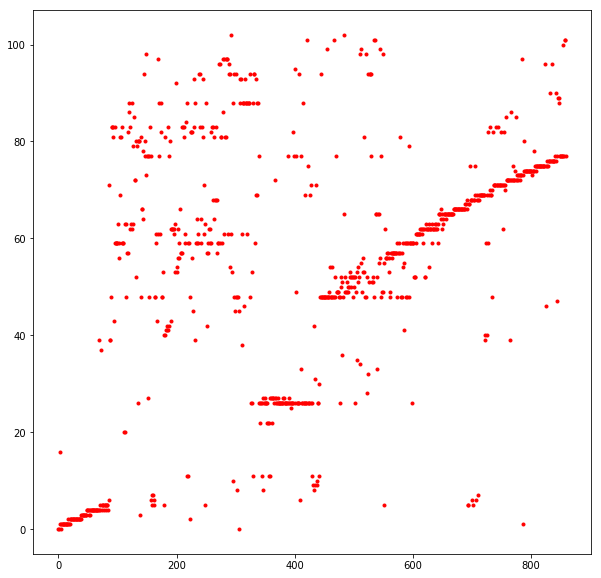

In [23]:
#plt.rcParams["figure.figsize"] = (10,10)
#plt.plot(global_max_index,'r.')
#plt.show()

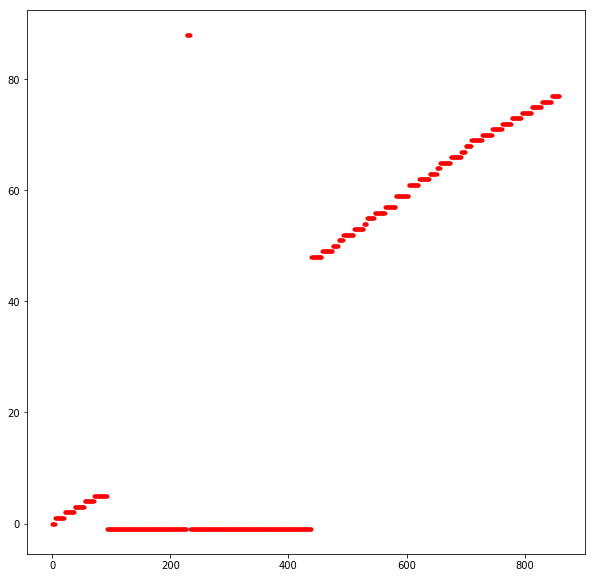

In [24]:
#plt.plot(test_y,'r.')
#plt.show()

In [25]:
'''
for i in range(len(result_test)):

    print(result_test[i])
'''

tensor([-4.7062e-02, -3.8071e+00, -8.0499e+00, -1.5305e+01, -3.0109e+01,
        -3.0051e+01, -3.3278e+01, -1.7567e+01, -4.2566e+00, -1.4548e+01,
        -2.0348e+01, -1.2706e+01, -2.1874e+01, -6.2545e+00, -1.4843e+01,
        -2.6289e+01, -1.1467e+01, -2.7856e+01, -2.5249e+01, -6.8457e+00,
        -1.9893e+01, -3.1372e+01, -1.3367e+01, -2.0212e+01, -2.3462e+01,
        -2.7594e+01, -7.7780e+00, -1.0608e+01, -3.2726e+01, -2.4946e+01,
        -2.3714e+01, -1.8228e+01, -2.8282e+01, -1.9195e+01, -2.0421e+01,
        -1.1773e+01, -1.7611e+01, -1.0387e+01, -1.9743e+01, -3.3138e+01,
        -2.6289e+01, -3.8545e+01, -3.5246e+01, -3.9574e+01, -2.1449e+01,
        -2.1364e+01, -1.9060e+01, -2.1395e+01, -1.3693e+01, -2.6766e+01,
        -2.8484e+01, -3.1997e+01, -2.7652e+01, -3.2143e+01, -2.2949e+01,
        -1.9308e+01, -2.9544e+01, -3.7721e+01, -1.9457e+01, -1.7299e+01,
        -1.8430e+01, -1.3813e+01, -1.3969e+01, -1.5161e+01, -1.8438e+01,
        -2.3097e+01, -2.0241e+01, -2.4401e+01, -3.1

tensor([-17.9334, -17.5425, -14.9090,  -6.0468,  -4.0027,  -2.3363,  -9.0996,
         -9.6831, -13.9020, -16.8011,  -6.8812,  -4.3675,  -1.3393, -11.0539,
        -13.2236, -12.0609, -14.6695, -12.8469, -18.2111, -17.7497, -11.0559,
        -22.1396, -10.0401,  -4.0353,  -5.3999, -15.4896,  -6.2874, -13.0671,
        -19.2076, -14.9208, -22.9505,  -8.1268, -12.0277, -23.7296, -17.3258,
        -10.2305, -10.5901,  -3.8654,  -3.0220,  -0.6823, -14.9596, -11.1679,
        -11.4474, -12.9581, -14.1136, -15.7910, -15.9968, -19.0986, -13.9936,
        -19.7392, -19.0643, -15.9608, -17.7092,  -9.5807, -13.7675, -10.7195,
        -14.5442, -17.6429,  -9.5219, -17.4930, -17.3792, -19.5421, -15.6608,
        -21.0313, -18.4152, -16.7746, -18.3202, -11.2175, -11.7986,  -5.2288,
         -8.4567, -12.8563,  -8.5376, -16.7999, -16.0909, -12.2819, -23.2924,
        -13.1188, -12.9963, -11.0855, -12.6822,  -9.8375, -10.9364, -17.6049,
        -21.1458, -21.4739, -11.1771, -20.2447,  -6.8785, -13.88

tensor([-17.6134, -23.4504, -23.3307, -22.9843, -32.5607, -23.6717, -23.7705,
        -30.8960, -20.1385, -13.0374, -16.6509, -11.3848, -15.7276, -20.8203,
        -14.2747, -30.3109, -33.2700, -41.3484, -16.6363, -22.3191, -22.7978,
        -21.3875, -33.0775, -19.6823, -24.5686, -14.0924, -11.3871, -17.2538,
        -21.9102, -18.6839, -18.3970, -20.4721, -24.4249, -25.5089, -33.8309,
        -39.1044, -33.3549, -33.5763, -28.6022, -20.4507, -18.0201, -13.7298,
        -14.6660, -11.9362, -13.6889, -14.8435, -14.2929, -19.0764, -17.5085,
        -20.5410, -12.8340, -15.1935, -16.9006, -22.8860, -24.3885, -19.3279,
        -20.1189, -19.2136, -20.5796, -12.9801, -10.9597, -10.9806, -10.5775,
         -5.1553,  -9.0469, -10.9177, -12.8654, -16.8155, -24.1423, -20.4017,
        -12.0776,  -8.9160,  -6.7460, -14.7968, -12.8206, -13.7113, -16.5363,
        -17.0957, -15.1191,  -5.8023,  -0.1453, -18.1221, -12.0410,  -8.1207,
         -5.8169,  -2.1124,  -7.7754, -18.5503, -10.2156, -22.23

tensor([-23.3546, -41.6082, -29.5599, -32.6041, -35.4528, -16.1361, -20.4727,
        -26.1200, -27.6209, -30.1973, -29.7185, -18.0049, -34.9957, -48.5336,
        -42.0375, -47.0615, -38.8024, -41.8665, -50.4673, -34.6011, -25.1471,
        -45.6412, -41.1458, -31.6469, -37.5996, -38.2460, -15.4198, -25.6077,
        -19.1423, -33.9160, -21.4079, -36.5983, -24.2807, -30.5519, -35.1058,
        -25.3078, -41.1002, -34.0693, -34.2221, -34.7683, -27.0476, -36.3148,
        -18.8200, -30.2381, -23.7385, -18.4686, -20.2058, -30.5310, -17.3646,
        -14.8831, -18.5522,  -8.4643,  -4.9108, -16.7256,  -0.5857, -18.9781,
        -26.0508, -21.7551, -24.4793,  -6.3758, -15.1570,  -8.8668,  -0.8639,
        -15.9820, -14.2542, -15.3114, -20.6768, -28.3583, -28.1364, -29.4006,
        -47.7554, -31.6910, -34.4142, -38.5796, -37.4292, -44.7524, -37.9256,
        -14.1456, -40.3500, -27.7845, -25.6028, -24.4489, -12.2061, -13.0965,
        -18.1631,  -7.8088, -22.8171, -32.7550, -12.4401, -24.61

tensor([-15.9370, -16.3039, -25.4898, -21.8625, -21.8109,  -3.2566, -15.8574,
        -17.1546, -27.7336, -18.5974, -24.3049, -25.0160,  -4.7000, -26.4854,
        -28.6716, -17.7535, -29.1203, -18.3735, -31.0570, -25.6736, -29.5513,
        -33.1406,  -9.3227, -14.1674, -27.6596, -24.7703, -15.8875, -27.7875,
        -24.5333, -31.4788, -27.2083, -23.5743, -21.6206, -36.3768, -25.6550,
        -24.2401, -27.1971, -19.2703, -22.2483, -12.2355,  -9.4893,  -5.4046,
         -3.5262, -11.8787,  -7.1123,  -4.4129, -14.3251, -16.7141,  -5.9774,
        -32.3694, -20.6715, -18.9649, -25.0367, -17.0100, -10.9253, -21.8403,
        -10.7744,  -0.3401,  -8.9252,  -5.9218,  -9.0795,  -8.5615,  -5.2016,
        -12.3204, -18.5469, -13.1567, -17.8750, -11.7740, -10.6386,  -4.2856,
         -2.8336,  -5.2906, -11.2979, -14.8615, -19.8654, -16.2888, -19.9520,
        -12.6239, -12.3589, -13.4141, -13.5319, -10.0249, -10.1235,  -4.3373,
        -14.8855,  -7.4724,  -5.6175, -16.5564,  -2.4373, -10.82

tensor([-19.2399, -20.1682, -14.4415, -15.4052, -18.2009,  -1.4861, -14.7706,
         -9.6126,  -5.0758,  -8.5814,  -3.7518,  -4.9256,  -7.7293, -18.7710,
        -24.5060, -18.5779, -16.6451, -14.1660, -20.7052, -11.5500,  -8.8090,
        -17.0914,  -9.3096, -10.9412, -18.3135, -20.9855, -10.7537,  -9.9178,
        -18.3633, -22.6749, -21.1175, -11.5930, -18.5114, -24.0477, -18.5037,
        -14.1741, -11.0273, -10.7556, -12.7113,  -3.8642,  -5.9134,  -5.1141,
         -7.1235, -13.8673,  -8.7312, -12.0537, -12.1262, -17.0603,  -3.0786,
        -25.8231, -19.1491, -19.9926, -17.0771, -10.0602, -11.3418, -13.3273,
        -17.5435, -20.0449,  -4.3356,  -9.6450,  -7.4407,  -5.2022,  -8.7415,
        -18.8913, -15.6971, -14.7810, -21.6874, -17.3194, -17.5768,  -9.2400,
         -9.9871, -16.7477, -19.0276, -12.9176, -23.6617, -17.3022, -17.2168,
         -7.9171, -16.2737, -12.3014, -10.4515,  -5.4269,  -9.2616, -16.3894,
        -18.4855, -11.8793, -12.4734, -19.1583,  -0.4573, -13.18

tensor([-25.8099, -30.3040, -21.8848, -20.8376, -25.0397,  -3.9925, -11.7962,
        -15.0829, -24.8255, -24.9051, -25.0883, -20.5129, -43.1106, -38.9716,
        -39.5177, -25.1669, -23.9349, -27.1128, -37.9934, -14.5645, -18.3723,
        -14.8890, -25.6715, -24.9226, -24.6386, -19.6676,  -1.9572,  -6.4106,
         -9.3126, -29.0621, -15.2230, -34.7718, -23.5981, -17.8407, -33.4986,
        -20.6370, -28.3800, -31.4070, -26.1206, -32.8266, -21.4156, -16.0693,
        -18.9880, -30.7624, -25.0707, -19.9778, -36.8808, -24.4438, -23.7219,
         -5.6561, -36.0301, -20.5921, -28.5392, -25.2198, -23.6928, -45.3170,
        -30.1448, -33.7736, -14.0702, -23.5535, -21.7623, -24.7874, -23.4066,
        -33.1546, -17.4041, -28.8342, -16.1739, -19.2959, -32.7026, -22.9747,
        -43.8152, -20.2864, -44.6185, -39.5535, -23.5131, -35.8149, -22.3773,
         -0.1869, -28.3889, -30.3121, -25.4445, -15.3642, -12.6401, -17.4568,
        -17.5018, -16.2183, -22.7698, -21.9747, -23.9354, -28.21

tensor([-2.4123e+01, -2.7235e+01, -1.6837e+01, -1.4135e+01, -2.7742e+01,
        -3.1832e+01, -2.7223e+01, -3.0097e+01, -2.7755e+01, -2.9411e+01,
        -2.7154e+01, -3.2374e+01, -4.6699e+01, -4.6371e+01, -3.5383e+01,
        -3.5479e+01, -3.7019e+01, -4.6839e+01, -5.1395e+01, -2.2134e+01,
        -4.0221e+01, -3.0968e+01, -3.1839e+01, -3.1504e+01, -3.7526e+01,
        -3.0946e+01, -2.5914e+01, -2.1551e+01, -2.1570e+01, -3.0511e+01,
        -1.9828e+01, -3.2867e+01, -3.2133e+01, -2.9053e+01, -3.0417e+01,
        -2.7100e+01, -2.3948e+01, -3.1087e+01, -4.0599e+01, -3.3464e+01,
        -2.7471e+01, -3.1411e+01, -3.2351e+01, -1.8045e+01, -2.8266e+01,
        -2.4711e+01, -2.0572e+01, -2.1882e+01, -7.0974e+00, -4.6250e+00,
        -7.3137e+00, -1.6702e+01, -1.4503e+01, -2.2443e+01, -2.0505e+01,
        -3.3029e+01, -2.9631e+01, -2.8195e+01, -2.1267e+01, -1.5209e+01,
        -2.6382e+01, -2.4329e+01, -2.5729e+01, -2.3623e+01, -1.8522e+01,
        -1.6716e+01, -2.2995e+01, -2.2689e+01, -2.8

tensor([-20.7200, -22.5950, -19.5318, -16.8480, -26.1465, -18.6266, -17.5165,
        -20.0073, -20.1199, -20.6453, -20.5860, -10.6898, -33.9372, -29.8062,
        -25.0595, -27.6029, -24.1481, -30.9751, -41.5448, -23.4416, -19.9388,
        -30.1911, -35.5289, -25.1701, -27.4850, -24.1932, -12.4989,  -9.0171,
        -12.7562, -23.5193, -16.3814, -17.8413, -23.2167, -11.0019, -23.7807,
        -15.2603, -11.4614, -21.2633, -26.1987, -22.0083, -24.0684, -36.8608,
        -28.4336, -29.3294, -23.0690, -19.4644, -23.5068, -26.7809,  -7.8511,
         -9.0892, -14.3843, -10.8705,  -0.5180, -13.3977, -15.2408, -17.8310,
        -21.2646, -26.7437, -24.4214, -18.0918, -20.8347, -21.9343, -16.0734,
        -19.2639,  -7.8686, -10.6934, -21.7542, -22.9925, -32.4460, -26.5387,
        -37.0937, -36.9087, -36.8278, -30.3392, -30.1322, -37.5708, -36.6020,
        -14.3789, -31.2303, -30.0627, -16.4098, -19.5362, -13.2908, -20.3913,
        -19.9920, -20.8849, -24.0266, -37.6268, -16.0628, -23.21

tensor([-2.3985e+01, -3.1623e+01, -2.9942e+01, -2.9129e+01, -2.8840e+01,
        -7.3092e+00, -1.1906e+01, -1.5989e+01, -2.5364e+01, -3.4189e+01,
        -3.7100e+01, -1.9159e+01, -2.9746e+01, -4.4550e+01, -3.7716e+01,
        -3.5789e+01, -3.6154e+01, -3.1961e+01, -4.0344e+01, -2.2378e+01,
        -2.3247e+01, -3.3923e+01, -2.4877e+01, -1.9361e+01, -3.2061e+01,
        -4.2778e+01, -1.5781e+01, -2.0967e+01, -2.8274e+01, -3.4168e+01,
        -2.9352e+01, -2.6201e+01, -3.0130e+01, -4.1973e+01, -3.2221e+01,
        -3.4651e+01, -3.1561e+01, -2.7257e+01, -2.6698e+01, -8.8881e+00,
        -1.2023e+01, -1.5764e+01, -1.4266e+01, -6.6369e+00, -1.3125e+01,
        -1.9823e+01, -2.6227e+01, -2.5830e+01, -4.8669e+00, -1.7032e+01,
        -1.4369e+01, -1.6112e+01, -8.6828e+00, -5.7713e+00, -1.4445e+01,
        -1.2334e+01, -1.0374e+01, -1.1949e+01, -2.3073e+01, -1.7832e-02,
        -1.3667e+01, -9.7769e+00, -1.1616e+01, -1.9571e+01, -1.7422e+01,
        -2.4729e+01, -2.0194e+01, -1.9413e+01, -2.3

tensor([-1.7798e+01, -2.0237e+01, -4.3327e+01, -2.3863e+01, -3.7078e+01,
        -3.1615e+01, -2.5165e+01, -4.6927e+01, -3.8471e+01, -3.2108e+01,
        -3.4048e+01, -2.6537e+01, -3.4912e+01, -2.5819e+01, -3.0032e+01,
        -3.2915e+01, -2.7416e+01, -3.1212e+01, -5.2550e+01, -3.2104e+01,
        -3.6674e+01, -3.3186e+01, -3.1236e+01, -3.6154e+01, -4.2870e+01,
        -3.5679e+01, -2.3065e+01, -3.2816e+01, -2.4141e+01, -3.8220e+01,
        -3.5410e+01, -2.0267e+01, -3.0130e+01, -1.4857e+01, -3.5220e+01,
        -2.4831e+01, -2.8169e+01, -2.6864e+01, -4.3982e+01, -2.7938e+01,
        -3.2484e+01, -4.0799e+01, -3.3993e+01, -4.6071e+01, -3.1930e+01,
        -2.6753e+01, -3.3788e+01, -2.8642e+01, -1.2212e+01, -1.9931e+01,
        -2.2695e+01, -1.7224e+01, -1.1871e+01, -1.9757e+01, -1.3769e+01,
        -2.2664e+01, -2.2971e+01, -2.1549e+01, -3.4816e+01, -2.3209e+01,
        -2.8475e+01, -3.0098e+01, -8.6933e+00, -1.5265e+01, -1.2451e+01,
        -8.5068e-04, -7.3319e+00, -2.2627e+01, -4.2

tensor([-13.2950, -17.0297, -20.5902, -24.4517, -15.2266,  -2.1776, -13.1568,
        -18.3654, -10.4188, -11.8731, -20.8001, -15.0087, -12.6796, -22.2177,
        -22.7005, -18.8813, -24.8948, -26.3171, -33.6354, -22.5019, -21.0157,
        -18.2787, -19.0289, -14.6302, -17.5190, -11.1631,  -6.7809, -17.3602,
        -13.4430, -16.8176,  -8.7849, -15.3930, -15.4442, -21.8483, -19.3354,
         -9.1227, -15.5205,  -5.5125,  -4.1768,  -2.7337,  -4.4363,  -7.3151,
        -10.9421, -16.4654, -12.0656, -10.0490, -21.1380, -13.5821,  -5.1986,
        -11.1452, -15.0141,  -8.2455, -14.5588, -13.2897,  -5.2084, -14.3248,
        -10.5665,  -9.9217, -10.9560,  -9.8762, -12.7362, -11.1023,  -7.8498,
        -13.5178, -12.1891, -14.0307, -12.6835,  -8.7979,  -9.1982,  -0.4089,
         -7.6281,  -7.5917, -17.6701, -13.7099, -20.8989, -25.7567, -24.8208,
         -8.3464, -15.1250, -17.9966, -15.9808, -10.9859,  -4.1619,  -2.3775,
         -9.1782, -11.2331, -22.7255, -25.0428, -12.7769, -23.72

tensor([-14.5150,  -6.9634, -12.4879, -12.7965, -16.0856, -11.8680, -11.6997,
        -14.3684, -19.5858, -21.2780, -17.8495, -14.0712, -12.5808, -17.8884,
        -19.0937, -20.3324, -25.7991, -28.2378, -30.8670, -18.9838, -25.0362,
        -22.7233, -19.0740, -11.9515, -11.8153, -13.9202, -13.9212, -13.5240,
        -18.6987, -22.1488, -25.1195, -19.4228, -18.9264, -27.2503, -27.2873,
        -25.5211, -22.0505, -18.2724, -15.3147, -10.3231, -13.0523,  -8.5549,
        -13.6203, -10.4554, -15.3502, -14.7610,  -9.7320,  -7.8252, -15.2786,
        -18.8701, -16.7592, -14.5553, -24.6119, -25.3619, -16.3274, -25.0517,
        -16.3729, -12.7648, -13.3425, -18.5793, -15.3505, -12.2371, -15.9245,
        -17.4503, -21.1168, -16.4098, -12.6600,  -8.4910, -13.4567, -13.0016,
        -15.5358,  -4.0431,  -9.2310,  -5.2374,  -0.2087,  -9.5336,  -6.9556,
         -3.2150,  -2.1119, -10.8153, -10.0242, -17.7740,  -9.1021,  -9.8374,
        -13.2111,  -7.1242, -14.7748,  -9.0387,  -9.5594, -11.40

tensor([-10.8523, -15.0006, -11.6245,  -7.2534, -16.5446, -19.3743, -19.7821,
        -20.0390, -16.9654, -14.5489, -11.5646, -12.9638, -17.7159, -12.0249,
        -11.8820, -16.3481, -16.2373, -15.7825,  -7.7216,  -5.8113, -14.5582,
         -7.1282, -12.5916, -13.8324, -13.9227,  -9.5057,  -6.0480, -12.2098,
        -14.1003, -14.3084, -12.3259, -18.2938, -20.3890, -13.4032, -15.5435,
        -17.7394, -12.0352, -15.1762, -19.3507, -15.8244, -13.0275, -11.9932,
         -9.2064, -10.6892,  -7.6800,  -5.9966,  -7.6045,  -8.6934, -12.1988,
         -9.8708,  -9.8966, -15.7046, -15.8438, -13.8673, -15.3055, -15.7228,
        -13.6366, -17.2708, -10.5654, -14.5288, -14.1987, -12.1408, -14.8222,
        -14.2997, -10.2687,  -9.2077, -10.2792, -13.6459, -18.0593, -14.9215,
         -9.5560,  -8.8767, -11.9978, -12.0710, -10.7243,  -8.4285,  -8.2308,
         -1.5030, -15.5801, -17.1887, -10.1103, -17.0318, -15.5759, -15.5853,
        -13.6406, -14.4085, -11.1987, -13.2723,  -7.6606,  -8.75

In [26]:
acc = 0

for i in range(len(global_max_index)):
    if((test_y[i] in adj[global_max_index[i]]) or (test_y[i] == global_max_index[i])):
        print(i, test_y[i], global_max_index[i])
        acc+=1
print(acc/float(len(global_max_index)))

(0, 0, 0)
(1, 0, 0)
(3, 0, 1)
(4, 0, 0)
(5, 1, 1)
(6, 1, 1)
(7, 1, 1)
(8, 1, 1)
(9, 1, 1)
(10, 1, 1)
(11, 1, 1)
(12, 1, 1)
(13, 1, 1)
(14, 1, 1)
(15, 1, 1)
(16, 1, 2)
(17, 1, 1)
(18, 1, 1)
(19, 1, 2)
(20, 1, 1)
(21, 2, 2)
(22, 2, 2)
(23, 2, 2)
(24, 2, 2)
(25, 2, 2)
(26, 2, 2)
(27, 2, 2)
(28, 2, 2)
(29, 2, 2)
(30, 2, 2)
(31, 2, 2)
(32, 2, 2)
(33, 2, 2)
(34, 2, 2)
(35, 2, 2)
(36, 2, 2)
(37, 2, 2)
(38, 3, 3)
(39, 3, 2)
(40, 3, 3)
(41, 3, 3)
(42, 3, 3)
(43, 3, 3)
(44, 3, 3)
(45, 3, 3)
(46, 3, 3)
(47, 3, 3)
(48, 3, 4)
(49, 3, 4)
(50, 3, 4)
(51, 3, 3)
(52, 3, 4)
(53, 3, 3)
(54, 3, 4)
(55, 4, 4)
(56, 4, 4)
(57, 4, 4)
(58, 4, 4)
(59, 4, 4)
(60, 4, 4)
(61, 4, 4)
(62, 4, 4)
(63, 4, 4)
(64, 4, 4)
(65, 4, 4)
(66, 4, 4)
(67, 4, 4)
(68, 4, 4)
(70, 4, 4)
(71, 5, 5)
(73, 5, 4)
(74, 5, 5)
(75, 5, 5)
(76, 5, 5)
(77, 5, 4)
(78, 5, 5)
(79, 5, 5)
(80, 5, 4)
(81, 5, 5)
(82, 5, 5)
(83, 5, 5)
(84, 5, 4)
(85, 5, 6)
(232, 88, 88)
(443, 48, 48)
(444, 48, 48)
(446, 48, 48)
(447, 48, 48)
(448, 48, 48)
(449, 48, 48

In [27]:
result_test = result_test.cpu().numpy()
p = np.exp(result_test)
global_max_value = np.exp(global_max_value)
for i in range(len(result_test)):

    print(p[i])

[  9.54028308e-01   2.22114362e-02   3.19140207e-04   2.25384909e-07
   8.38887133e-14   8.89212342e-14   3.52716420e-15   2.34749642e-08
   1.41709754e-02   4.80707911e-07   1.45569812e-09   3.03293041e-06
   3.16559945e-10   1.92178402e-03   3.57920612e-07   3.82620238e-12
   1.04687751e-05   7.98864447e-13   1.08285126e-11   1.06404524e-03
   2.29279640e-09   2.37270666e-14   1.56542615e-06   1.66669800e-09
   6.46685414e-11   1.03732528e-12   4.18860669e-04   2.47121316e-05
   6.13030101e-15   1.46539395e-11   5.02406242e-11   1.21280479e-08
   5.21510352e-13   4.61117011e-09   1.35259637e-09   7.70934730e-06
   2.24659029e-08   3.08391827e-05   2.66501199e-09   4.05741868e-15
   3.82571362e-12   1.82080783e-17   4.93122888e-16   6.50466048e-18
   4.84022933e-10   5.26741484e-10   5.27820898e-09   5.10798348e-10
   1.13021588e-06   2.37575671e-12   4.26228470e-13   1.27031877e-14
   9.79553027e-13   1.09808462e-14   1.07988382e-10   4.11922052e-09
   1.47703776e-13   4.14988010e-17

   7.20773623e-15   3.17605355e-08   2.85435356e-11   6.40083708e-10]
[  6.45714764e-13   4.42238680e-14   1.81751354e-15   3.87376264e-09
   9.22452603e-09   8.72595629e-05   8.04065905e-07   6.86117092e-12
   1.15584842e-11   1.63173954e-08   5.73392042e-14   9.78427582e-12
   2.14182708e-12   1.27190972e-17   1.15745210e-15   1.86084806e-12
   7.83977962e-17   5.25882324e-17   3.71612545e-18   1.66918874e-13
   1.00618368e-11   3.21809159e-12   3.49356877e-10   6.35608188e-09
   6.54841383e-15   3.55594755e-11   3.03396128e-11   3.45316865e-11
   1.18415555e-10   4.45113679e-09   1.07180611e-08   5.33959613e-11
   3.16470600e-10   3.34707864e-15   1.29159078e-15   2.48620878e-15
   6.50752459e-15   5.70337440e-12   2.75719447e-11   7.50329320e-07
   1.03570195e-03   1.25029562e-02   3.22856104e-05   1.38659859e-02
   1.78977788e-09   7.00994644e-12   2.50852516e-11   1.24956337e-10
   3.29047162e-03   7.74805002e-08   4.03461371e-08   2.99716845e-07
   7.23514063e-07   1.03096411e-0

   7.50698632e-07   5.98139104e-06   7.77503994e-15   4.94888752e-08]
[  2.83095775e-15   1.08126577e-23   1.93225420e-23   9.80871459e-16
   3.27695561e-18   1.67539205e-10   2.07803542e-14   1.02885625e-12
   2.79612244e-13   6.77575554e-06   9.68725967e-14   6.52642138e-14
   5.06177669e-11   4.33026437e-17   4.23792113e-11   1.42548274e-07
   2.59119481e-09   9.85605293e-04   2.70835130e-07   2.44581716e-10
   9.87432003e-01   9.93857043e-07   6.51603074e-08   3.30496091e-12
   6.13485015e-19   7.43541079e-12   1.84073026e-12   5.25748215e-16
   2.53008858e-09   1.82121350e-14   3.13155226e-08   1.39020644e-08
   1.04868203e-09   9.09018283e-08   5.39306143e-07   2.27522154e-10
   2.19641289e-18   5.63189771e-16   1.68808205e-13   1.04020056e-11
   1.53214314e-05   5.46837509e-09   1.70846831e-03   1.87864657e-07
   6.74809306e-11   2.29901701e-07   7.46045868e-15   8.00480711e-18
   5.05170878e-03   5.01054309e-10   9.07366426e-14   5.12503180e-14
   5.12112353e-10   1.04747029e-0

[  2.37574636e-13   1.50340854e-13   3.76797308e-13   8.79449361e-11
   1.39238420e-13   1.82777899e-06   5.79299846e-13   1.30523418e-07
   4.78751283e-12   1.02149235e-12   2.70134070e-14   5.26197974e-11
   2.90943918e-12   4.70948044e-19   2.40964145e-16   7.68613020e-11
   1.22885209e-13   3.40291415e-04   2.13696762e-06   6.07181050e-07
   1.16722148e-07   7.13195225e-10   2.11486367e-05   1.57038577e-10
   8.68870515e-18   1.02332490e-13   5.75972240e-14   1.31608642e-14
   7.54712921e-16   4.21547221e-17   1.04786812e-13   2.23806081e-13
   1.77551336e-14   2.27126146e-15   9.17162532e-14   4.81366147e-09
   3.29550298e-14   1.57344606e-11   6.37555513e-06   9.96570339e-13
   1.92069180e-07   3.82316827e-08   3.63283057e-08   6.36005495e-03
   7.18644005e-05   8.15250794e-04   1.28437228e-09   7.01802332e-13
   5.41344358e-10   7.92450827e-10   4.07235028e-08   5.54291890e-10
   2.17389941e-04   9.73483384e-01   2.19380978e-04   1.05728570e-04
   1.40750047e-03   3.48978113e-09

   1.15771741e-07   2.12313298e-05   3.83660023e-07   5.53572718e-05]
[  7.03552272e-03   1.78274186e-03   1.27643361e-04   1.79864932e-04
   2.74932177e-06   2.86861251e-07   2.04055982e-06   1.87484588e-08
   4.94747887e-09   6.20219225e-07   1.38149362e-05   3.38066275e-06
   5.55640213e-07   2.11570272e-09   5.74640524e-07   8.98945096e-09
   1.04257630e-07   1.18299459e-11   3.95813027e-09   2.34764011e-04
   1.57154539e-10   2.49718646e-08   1.45489949e-08   4.40457961e-06
   1.08786530e-07   3.08612783e-07   1.47204672e-04   1.07303356e-04
   8.10209997e-07   1.63250853e-08   5.73735615e-10   3.09869214e-10
   3.29367478e-10   4.36538696e-12   6.76803336e-11   3.00634873e-09
   3.42736648e-08   4.92206809e-08   9.84721082e-10   2.06251061e-05
   2.49077100e-03   2.34442268e-06   1.12110829e-04   8.99055340e-06
   3.45686794e-06   7.03696787e-06   5.81466146e-02   1.37719028e-02
   1.77804470e-01   1.64921963e-04   1.72681630e-01   1.77138878e-04
   2.06948528e-07   4.70626926e-1

[  6.95431547e-04   5.60804445e-04   1.38926225e-05   2.53695846e-01
   2.72499368e-04   1.05722506e-06   3.25358906e-10   1.76958031e-06
   1.48750075e-06   1.66992697e-10   1.79706063e-07   4.35888156e-04
   3.91555288e-10   5.03782083e-08   1.55789839e-05   5.51899824e-08
   2.39649686e-04   3.69485669e-08   1.57977862e-08   5.07223513e-03
   2.22438756e-09   2.18850914e-07   8.33256841e-09   4.77138747e-06
   1.23499975e-08   6.60346040e-12   7.92946521e-05   5.83277259e-04
   5.02786805e-11   6.87172013e-14   2.29779917e-10   9.06531952e-08
   7.17721299e-11   1.65330648e-11   3.92368836e-13   3.31979400e-09
   1.20871675e-07   5.90476702e-05   1.67409212e-06   1.33400157e-04
   1.78500173e-07   4.50090241e-08   2.64835844e-11   2.81488504e-08
   2.11756188e-07   8.99614975e-07   3.45396169e-04   7.36456559e-06
   2.87509859e-01   9.18100486e-05   2.12862418e-04   5.18074921e-06
   1.32439816e-02   3.48831897e-08   4.12107329e-06   6.34194641e-10
   1.42515353e-13   6.49049245e-15

[  5.29919326e-08   1.40472448e-05   9.51449154e-04   3.07059643e-04
   1.69136096e-04   3.02207452e-04   2.67935206e-07   2.13727544e-04
   4.54414195e-09   9.46721521e-12   2.53309935e-07   4.02338846e-05
   2.31733660e-10   9.27378938e-11   1.70998701e-11   4.01510903e-07
   6.22952541e-07   1.90412408e-11   4.86473722e-14   1.19338699e-01
   3.62341694e-13   1.08465592e-07   2.21573369e-04   5.70266275e-06
   1.56700553e-09   1.10600236e-11   3.38835598e-05   8.19900539e-03
   1.85684718e-10   4.71459470e-15   8.47093298e-11   6.02131331e-11
   2.33521969e-12   1.39853186e-14   4.02478615e-14   2.42557832e-08
   1.53296896e-05   4.39336993e-08   2.48822881e-12   1.04166197e-07
   7.94799507e-06   2.84086781e-07   1.69555871e-13   4.56144428e-11
   7.58611236e-08   1.72988734e-10   7.63020182e-07   3.85602439e-10
   1.60138967e-04   1.39965012e-10   1.55969348e-04   9.48923571e-08
   1.40070733e-05   1.64190384e-09   6.74734736e-07   5.17650803e-15
   6.56429570e-15   2.77637292e-14

[  3.14953468e-08   9.88158028e-11   5.06890974e-10   9.73852802e-05
   1.11477209e-06   2.49592574e-07   5.32771136e-12   1.91293537e-09
   2.14984638e-07   1.87858954e-01   4.33913767e-01   4.05268148e-02
   2.48358632e-03   3.84539362e-06   1.54200860e-03   6.04455825e-04
   7.91180677e-10   1.72499938e-12   3.87931977e-05   9.38953804e-10
   2.00104041e-04   1.59582216e-02   8.32783353e-09   7.02842735e-05
   1.04883114e-07   1.64301767e-07   2.74471881e-06   9.55344294e-04
   6.74923228e-09   6.26003020e-05   5.24367625e-03   3.26822774e-04
   8.75629994e-05   2.39981368e-11   3.76614331e-08   2.77936125e-14
   9.04238195e-09   6.54866439e-11   1.47978518e-08   1.98566499e-06
   1.57983141e-06   5.24231640e-04   9.57309753e-02   4.12030931e-05
   6.08331234e-08   1.04345407e-10   7.75823850e-12   9.63282318e-12
   1.12040599e-08   1.21183297e-09   2.13046807e-08   5.29746472e-12
   1.66658104e-12   8.77694445e-12   5.02666917e-15   7.33861669e-12
   2.99409511e-14   2.55692828e-11

   3.34071171e-16   9.73661418e-09   6.04956585e-10   1.27683567e-11]
[  6.52264287e-09   5.70931982e-11   4.04320640e-14   2.75788636e-09
   6.71436311e-08   1.79800008e-05   2.51611820e-09   5.39351119e-10
   1.60234723e-08   5.30568620e-08   1.21078156e-13   1.29546152e-08
   4.08150022e-13   2.73296576e-13   2.65550693e-10   5.95007599e-10
   1.09571126e-08   7.52698293e-10   5.74757912e-16   1.21316279e-09
   1.13599541e-09   2.54082810e-10   1.48373946e-15   1.20424885e-11
   3.55439289e-12   3.48751345e-12   4.99075403e-09   8.65211014e-10
   1.80186049e-07   3.26470787e-15   2.59398149e-07   1.63435843e-07
   1.06895463e-07   6.46583720e-09   1.67277834e-12   1.28259492e-09
   3.21275602e-12   4.34294701e-12   1.43566506e-10   1.21837286e-06
   1.43948062e-08   1.23707267e-07   1.11708358e-08   3.14749407e-11
   2.28418638e-11   1.73197720e-10   3.13871243e-14   2.95769079e-13
   9.98797178e-01   1.21472876e-04   1.24035907e-07   3.02143036e-07
   8.95707519e-04   6.47292353e-0

[  2.24753862e-07   1.43609365e-12   1.09244423e-14   3.34951729e-08
   8.17332226e-12   1.51335109e-06   2.07074180e-08   1.03680302e-12
   6.44811765e-12   6.67495356e-13   7.35168382e-13   1.25868141e-07
   1.45842727e-09   1.53938626e-10   3.45971342e-12   5.88893517e-11
   2.56058738e-12   1.88305441e-10   1.56072541e-18   6.83737843e-13
   7.79790121e-10   4.73352741e-18   2.04754125e-09   4.58771199e-09
   6.80018601e-08   5.83750930e-13   3.22565690e-08   1.04223130e-09
   6.95229190e-08   3.73635879e-11   6.80290243e-14   1.16586130e-10
   8.08296099e-05   3.79469566e-05   1.58597834e-06   2.08457132e-05
   8.27967384e-08   9.44824948e-04   2.09922392e-11   2.09292722e-11
   1.27850920e-12   1.02206036e-14   1.53470934e-11   4.06187331e-14
   4.71278615e-12   4.43166970e-09   3.62150657e-11   3.36198049e-11
   2.47377995e-02   3.02798412e-07   8.61950127e-07   3.12102497e-06
   3.38897166e-06   1.22194006e-05   4.29516862e-04   2.55133897e-01
   4.20185766e-04   1.48518040e-04

[  4.32769395e-03   4.28176996e-08   2.92303389e-06   2.99801172e-07
   1.22985242e-07   4.97496387e-07   6.17666054e-04   2.76815281e-05
   8.71378506e-06   1.97623422e-06   4.04919265e-04   2.39708299e-07
   1.35032747e-06   9.44861753e-08   8.80116113e-06   9.19957762e-04
   1.66203565e-04   9.30701662e-03   3.56812484e-06   5.35011850e-03
   2.77238360e-06   5.76812960e-03   1.16996773e-01   7.95904663e-04
   5.33657840e-05   2.79733667e-05   2.18088906e-02   3.69457460e-08
   2.36092706e-06   1.83127468e-05   9.62352860e-05   3.66218416e-07
   2.22650506e-02   2.90483058e-05   4.47655824e-04   2.40356382e-03
   2.28313598e-04   6.39301762e-02   2.56797578e-03   7.88788020e-06
   8.35645129e-04   9.59364144e-08   1.26128714e-06   1.86482509e-07
   6.17220008e-04   4.70607318e-02   1.08619006e-05   1.46417267e-04
   2.77627736e-01   1.88312232e-01   4.06060833e-03   9.71612986e-04
   7.95646192e-05   7.29923174e-02   1.21961748e-02   1.83863763e-03
   7.95383763e-04   1.18846685e-01

   4.42354320e-10   7.20206913e-07   4.98785440e-08   4.32364422e-10]
[  5.60555782e-04   3.08613352e-07   2.40733106e-12   6.73932732e-09
   8.50617580e-12   1.04573594e-09   5.65260194e-09   4.81235247e-15
   5.94558083e-11   3.51216070e-11   5.15947562e-11   5.21711172e-06
   2.26824545e-10   6.08957889e-05   4.83914714e-11   4.61695647e-11
   7.59845962e-13   1.93191973e-11   6.33661028e-15   2.84521939e-09
   9.20691735e-12   3.00122274e-08   1.02155576e-10   8.94519459e-11
   8.23101587e-09   3.72342504e-11   7.83800616e-08   9.83044757e-11
   1.17546424e-11   1.56461609e-13   2.05568917e-12   3.78658305e-09
   9.05564956e-10   5.38485381e-07   2.14701451e-11   3.45141586e-08
   7.19679889e-08   9.65586082e-07   7.23759594e-13   1.18324008e-08
   1.43555556e-10   6.68101642e-13   2.94963462e-13   8.06397135e-15
   3.73415574e-08   2.15168194e-09   1.33104790e-12   7.46248396e-10
   6.67375207e-05   5.38830813e-10   8.24729618e-09   2.08253734e-08
   1.02562649e-06   1.62795322e-0

   4.97335192e-14   5.14161824e-10   1.30414471e-10   1.35071555e-11]
[  3.02518863e-08   1.85089826e-04   3.58777660e-11   8.60804938e-09
   1.82556019e-11   3.02018105e-10   2.70218652e-06   1.77171862e-13
   5.83027865e-16   1.27706377e-16   2.76592722e-15   5.21788723e-10
   3.71624823e-13   1.15102716e-09   2.10263884e-14   1.72956885e-12
   1.71241358e-13   1.27770081e-18   2.88428156e-24   1.36152804e-14
   6.44743925e-20   6.13202554e-17   7.51046157e-14   1.53443508e-10
   6.96092295e-10   7.02882821e-11   6.56202531e-07   1.12634580e-11
   2.70940654e-06   6.87042876e-16   1.34627353e-15   1.44283592e-13
   1.10343436e-10   5.34994846e-13   1.14256685e-16   4.74784267e-10
   8.10984474e-11   2.68573705e-11   8.21668069e-16   1.20917011e-14
   1.55866687e-18   1.46185107e-15   1.98601403e-13   4.57051368e-17
   3.11583170e-14   6.74785070e-14   6.29252941e-15   2.52689918e-14
   7.73319690e-12   3.72005161e-12   1.08679142e-10   5.19622176e-08
   7.51783184e-13   1.11299425e-1

   6.85413740e-11   2.39025383e-10   5.46750281e-15   6.43552989e-10]
[  5.04801210e-06   5.69932679e-09   4.03922362e-09   1.61686255e-08
   1.12772324e-12   8.84956258e-12   1.25122093e-10   1.07256211e-13
   6.61617872e-09   1.19052103e-07   4.02947453e-09   3.23747251e-08
   1.82581026e-08   1.10790213e-08   1.76060979e-08   4.26708582e-12
   4.16351490e-14   1.55933213e-19   2.58367459e-12   5.92254991e-14
   1.27099069e-13   2.66199163e-11   5.14128670e-13   9.76107861e-10
   1.83755997e-11   2.02752326e-09   9.20759021e-07   9.45010825e-09
   1.91147462e-11   2.11173856e-10   3.63940345e-09   1.52799735e-11
   3.25703943e-11   2.70157030e-12   6.49777947e-14   7.53550288e-17
   3.11533530e-16   1.11286094e-14   6.02984862e-16   2.99483077e-11
   3.20869754e-11   9.64187202e-11   1.56450454e-07   4.53961384e-08
   3.17437271e-10   5.99234107e-10   1.20434711e-08   1.18293833e-07
   2.06392912e-07   5.77312781e-11   4.31268993e-10   2.54055544e-11
   5.13769630e-14   1.18535878e-1

   4.91846985e-17   2.31494755e-13   3.13526027e-14   1.90426644e-14]
[  2.38201083e-05   2.50715289e-07   2.37662846e-07   1.36074686e-06
   2.99358732e-10   7.74716327e-08   1.29749299e-06   6.23305796e-10
   7.39926181e-05   1.39497370e-05   2.38684297e-05   4.15910508e-05
   4.21355844e-06   8.08475306e-06   4.43183040e-07   7.65709926e-11
   1.78395303e-13   8.23038939e-16   6.21254825e-10   1.95995842e-09
   1.12908675e-10   5.59103519e-08   1.79778289e-10   2.54034376e-06
   6.96140489e-07   8.42587951e-07   1.94386079e-03   4.36288843e-07
   1.88278504e-10   2.29089037e-09   4.66084682e-09   6.78772594e-10
   1.30129785e-09   1.11410024e-12   2.03164111e-10   6.50228612e-12
   2.02357280e-11   7.05514050e-11   2.22292740e-10   4.27312421e-04
   1.01872429e-05   1.02379716e-04   1.74591376e-03   1.34463480e-04
   1.28707541e-06   1.67093219e-08   1.11985649e-03   1.06375901e-05
   4.23705314e-05   1.73254069e-08   1.24365022e-06   4.04634299e-08
   1.23401664e-10   1.51533885e-0

In [28]:
E = []
for i in range(len(global_max_index)):
    entropy = 0
    for j in range(len(p[i])):
        entropy -= p[i][j]*np.log2(p[i][j])
    E.append(entropy) 

In [29]:
for i in range(len(E)):
    print(i, global_max_index[i], test_y[i], global_max_value[i], E[i])

(0, 0, 0, 0.95402831, 0.35651058189449358)
(1, 0, 0, 0.63864887, 0.95144811936043006)
(2, 16, 0, 0.41829488, 2.273788708860673)
(3, 1, 0, 0.84225631, 0.65603628388437796)
(4, 0, 0, 0.59339082, 1.3082942355381442)
(5, 1, 1, 0.99993706, 0.0010231466790345508)
(6, 1, 1, 0.99945086, 0.0070426620094062812)
(7, 1, 1, 0.99895722, 0.012031648777146403)
(8, 1, 1, 0.99979401, 0.0028263146427472395)
(9, 1, 1, 0.99962622, 0.0054829363056812233)
(10, 1, 1, 0.99999237, 0.00015083043190893463)
(11, 1, 1, 0.62564856, 1.6541866990004475)
(12, 1, 1, 0.99154443, 0.081591399405329654)
(13, 1, 1, 0.992199, 0.071665425757124757)
(14, 1, 1, 0.99960333, 0.0050611530987441271)
(15, 1, 1, 0.95433956, 0.29581573408941375)
(16, 2, 1, 0.99958807, 0.0052560830561077711)
(17, 1, 1, 0.76720643, 1.3113462009865184)
(18, 1, 1, 0.93909955, 0.34526550214009144)
(19, 2, 1, 0.84401238, 0.63818568532060505)
(20, 1, 1, 0.99898392, 0.012722287035044527)
(21, 2, 2, 0.67404991, 0.95208781742810022)
(22, 2, 2, 0.99999809, 5.7191

In [30]:
match_result = []
acc = []
precision = []
recall = []
len_Q = len(p)
len_D = N
lost = True
position = -1
th1 = 0.97
th2 = 0.01
K = 2
'''
R = range(0,26)
for i in range(len(R)):
    R[i] /= 25.0
    '''

P = []
TN = []
FP = []
FN = []
FX = []

#for th1 in R:
    #for th2 in R:
for i in range(len_Q):
if lost:
    if global_max_value[i] < th1:
        match_result.append(-1)
        lost = True
    else:
        match_result.append(global_max_index[i])
        lost = False
        position = global_max_index[i]
else:
    left = max(position-K,0)
    right = min(position+K+1,len_D-1)
    local_max_value = max(p[i][left:right])
    local_max_index = p[i][left:right].argmax() + left
    if local_max_value < th2:

        if global_max_value[i] < th1:
            match_result.append(-1)
            lost = True
        else:
            match_result.append(global_max_index[i])
            position = global_max_index[i]
            lost = False
    else:
        match_result.append(local_max_index)
        position = local_max_index
        lost = False
print("time :", time.time() - start) 
'''  

        tp = 0
        tn = 0
        fp = 0
        fn = 0
        fx = 0
        for i in range(len_Q):
            if (test_y[i] == -1) and (match_result[i] == -1):
                tn += 1
            elif (test_y[i] == -1) and (match_result[i] != -1):
                fp += 1
            elif (test_y[i] != -1) and (match_result[i] == -1):
                fn += 1
            elif(test_y[i] in adj[int(match_result[i])]) or (test_y[i] == match_result[i]):
                tp += 1
            else:
                fx += 1
        TP.append(tp)
        TN.append(tn)
        FP.append(fp)
        FN.append(fn)
        FX.append(fx)
        precision.append((tp+0.001)/(tp+fp+fx*0.5+0.001))
        recall.append((tp+0.001)/(tp+fn+fx*0.5+0.001))
        acc.append((tp+tn)/float(fp+fn+tp+tn+fx))
        match_result = []

print(acc[:].index(max(acc[:])))
print(max(acc))
print(acc)
'''

IndentationError: unexpected indent (<ipython-input-30-c8c14dd6492e>, line 26)

In [ ]:
print(precision)
print(recall)
#axes = plt.gca()
#axes.set_ylim([0,1])
#axes.set_xlim([0,1])
for i in range(len(precision)):
    precision[i] = round(precision[i],3)
    recall[i] = round(recall[i],3)
    
plt.title("precision-recall")

plt.scatter(recall,precision)
plt.plot(recall,precision,'b')
plt.show()
print(precision)
print(recall)

In [ ]:
print(acc)

In [ ]:
plt.plot(acc,'r.')
plt.show()

In [ ]:
match_result = []
acc = []
precision = []
recall = []
len_Q = len(p)
len_D = N
lost = True
position = -1
th1 = 0.01
th2 = 0.05
K = 2

R = range(1,101)
for i in range(len(R)):
    R[i] /= 100.0
ER = range(1,101)
for i in range(len(ER)):
    ER[i] /= 10.0
TP = []
TN = []
FP = []
FN = []
FX = []

for th1 in ER:
    for th2 in R:
        for i in range(len_Q):
            if lost:
                if E[i] > th1:
                    match_result.append(-1)
                    lost = True
                else:
                    match_result.append(global_max_index[i])
                    lost = False
                    position = global_max_index[i]
            else:
                left = max(position-K,0)
                right = min(position+K+1,len_D-1)
                local_max_value = max(p[i][left:right])
                local_max_index = p[i][left:right].argmax() + left
                if local_max_value < th2:

                    if E[i] > th1:
                        match_result.append(-1)
                        lost = True
                    else:
                        match_result.append(global_max_index[i])
                        position = global_max_index[i]
                        lost = False
                else:
                    match_result.append(local_max_index)
                    position = local_max_index
                    lost = False

        tp = 0
        tn = 0
        fp = 0
        fn = 0
        fx = 0
        for i in range(len_Q):
            if (test_y[i] == -1) and (match_result[i] == -1):
                tn += 1
            elif (test_y[i] == -1) and (match_result[i] != -1):
                fp += 1
            elif (test_y[i] != -1) and (match_result[i] == -1):
                fn += 1
            elif(test_y[i] in adj[int(match_result[i])]) or (test_y[i] == match_result[i]):
                tp += 1
            else:
                fx += 1
        TP.append(tp)
        TN.append(tn)
        FP.append(fp)
        FN.append(fn)
        FX.append(fx)
        precision.append(tp+0.001/float(tp+fp+0.001))
        recall.append(tp+0.001/float(tp+fn+0.001))
        acc.append((tp+tn)/float(fp+fn+tp+tn+fx))
        match_result = []
print(acc[:].index(max(acc[:])))
print(max(acc))

In [ ]:
match_result = []
acc = []
precision = []
recall = []
len_Q = len(p)
len_D = N
lost = True
position = -1
th1 = 0.4
th2 = 0.01
K = 2

for i in range(len_Q):
    if lost:
        if global_max_value[i] < th1:
            match_result.append(-1)
            lost = True
        else:
            match_result.append(global_max_index[i])
            lost = False
            position = global_max_index[i]
    else:
        left = max(position-K,0)
        right = min(position+K+1,len_D-1)
        local_max_value = max(p[i][left:right])
        local_max_index = p[i][left:right].argmax() + left
        if local_max_value < th2:

            if global_max_value[i] < th1:
                match_result.append(-1)
                lost = True
            else:
                match_result.append(global_max_index[i])
                position = global_max_index[i]
                lost = False
        else:
            match_result.append(local_max_index)
            position = local_max_index
            lost = False
tp = 0
tn = 0
fp = 0
fn = 0
fx = 0
for i in range(len_Q):
    if (test_y[i] == -1) and (match_result[i] == -1):
        tn += 1
    elif (test_y[i] == -1) and (match_result[i] != -1):
        fp += 1
    elif (test_y[i] != -1) and (match_result[i] == -1):
        fn += 1
    elif(test_y[i] in adj[int(match_result[i])]) or (test_y[i] == match_result[i]):
        tp += 1
    else:
        fx += 1
acc_ = (tp+tn)/float(tp+tn+fp+fn+fx)
print(acc_)

In [ ]:
match_result


In [ ]:
print('TP :',tp)
print('TN :',tn)
print('FP :',fp)
print('FN :',fn)
print('FX :',fx)

In [ ]:
plt.plot(match_result,'r.')
plt.show()

In [ ]:
plt.plot(test_y,'r.')
plt.show()

In [ ]:
print('TP :',TP)
print('TN :',TN)
print('FP :',FP)
print('FN :',FN)
print('FX :',FX)
M = acc.index(max(acc))
print(TP[M],TN[M],FP[M],FN[M],FX[M])
plt.plot(acc,'b.')
plt.show()

In [ ]:
axes = plt.gca()
axes.set_ylim([0,1])
axes.set_xlim([0,1])
plt.title("precision-recall")

plt.scatter(recall,precision)
plt.plot(recall,precision,'b')
plt.show()
print(recall)
print(precision)

In [ ]:
match_result

In [ ]:
plt.plot(match_result,'r.')
plt.show()

In [ ]:
TP = 0
TN = 0
FP = 0
FN = 0
for i in range(len(E)):
    if (test_y[i] == -1) and (match_result[i] == -1):
        TN += 1
    elif (test_y[i] == -1) and (match_result[i] != -1):
        FP += 1
    elif(test_y[i] - match_result[i]) < 2:
        TP += 1
    else:
        FN += 1


In [ ]:
fasfasf
th = 0.13
local_max_index = []
match = []
for i in range(len(E)):
    if i == 0:
        match.append(global_max_index[i])
        local_max_index.append(global_max_index[i])
        continue
    prev_index = match[i-1]
    if prev_index == -1:
        match.append(global_max_index[i])
        local_max_index.append(global_max_index[i])
        continue
            
    if result_test[i][prev_index] > result_test[i][(prev_index+1)%146]:
        local_max_index.append(prev_index)
    else:
        local_max_index.append((prev_index+1)%146)
    if global_max_index[i] == local_max_index[i]:
        match.append(global_max_index[i])
    elif E[i] > 4:
        match.append(-1)
    elif E[i] > th:
        match.append(local_max_index[i])
    elif E[i] <= th :
        match.append(global_max_index[i])
        
print(sum((abs(test_y_2.data.cpu().numpy() - match < 2))) / float(len(test_y_2.data.cpu().numpy()))) 
plt.plot(match,'r.')
plt.show()

In [ ]:
print(sum((abs(test_y_2.data.cpu().numpy() - match < 2))) / float(len(test_y_2.data.cpu().numpy())))

In [ ]:
match

In [ ]:
plt.plot(local_max_index,'r.')
plt.show()